In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [2]:
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("Data scaled and ready for clustering.")

Data scaled and ready for clustering.


In [3]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

agg_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg_model.fit_predict(X_scaled)


dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

print("All four clustering models have been trained.")

All four clustering models have been trained.


In [4]:
def calculate_silhouette(X, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        return silhouette_score(X, labels)
    else:
        return -1

scores = {
    "K-Means": calculate_silhouette(X_scaled, kmeans_labels),
    "Hierarchical": calculate_silhouette(X_scaled, agg_labels),
    "DBSCAN": calculate_silhouette(X_scaled, dbscan_labels),
}

results_df = pd.DataFrame(list(scores.items()), columns=['Algorithm', 'Silhouette Score'])
display(results_df.sort_values(by='Silhouette Score', ascending=False))

,Algorithm,Silhouette Score
0,K-Means,0.548287
1,Hierarchical,0.264609
2,DBSCAN,0.195811


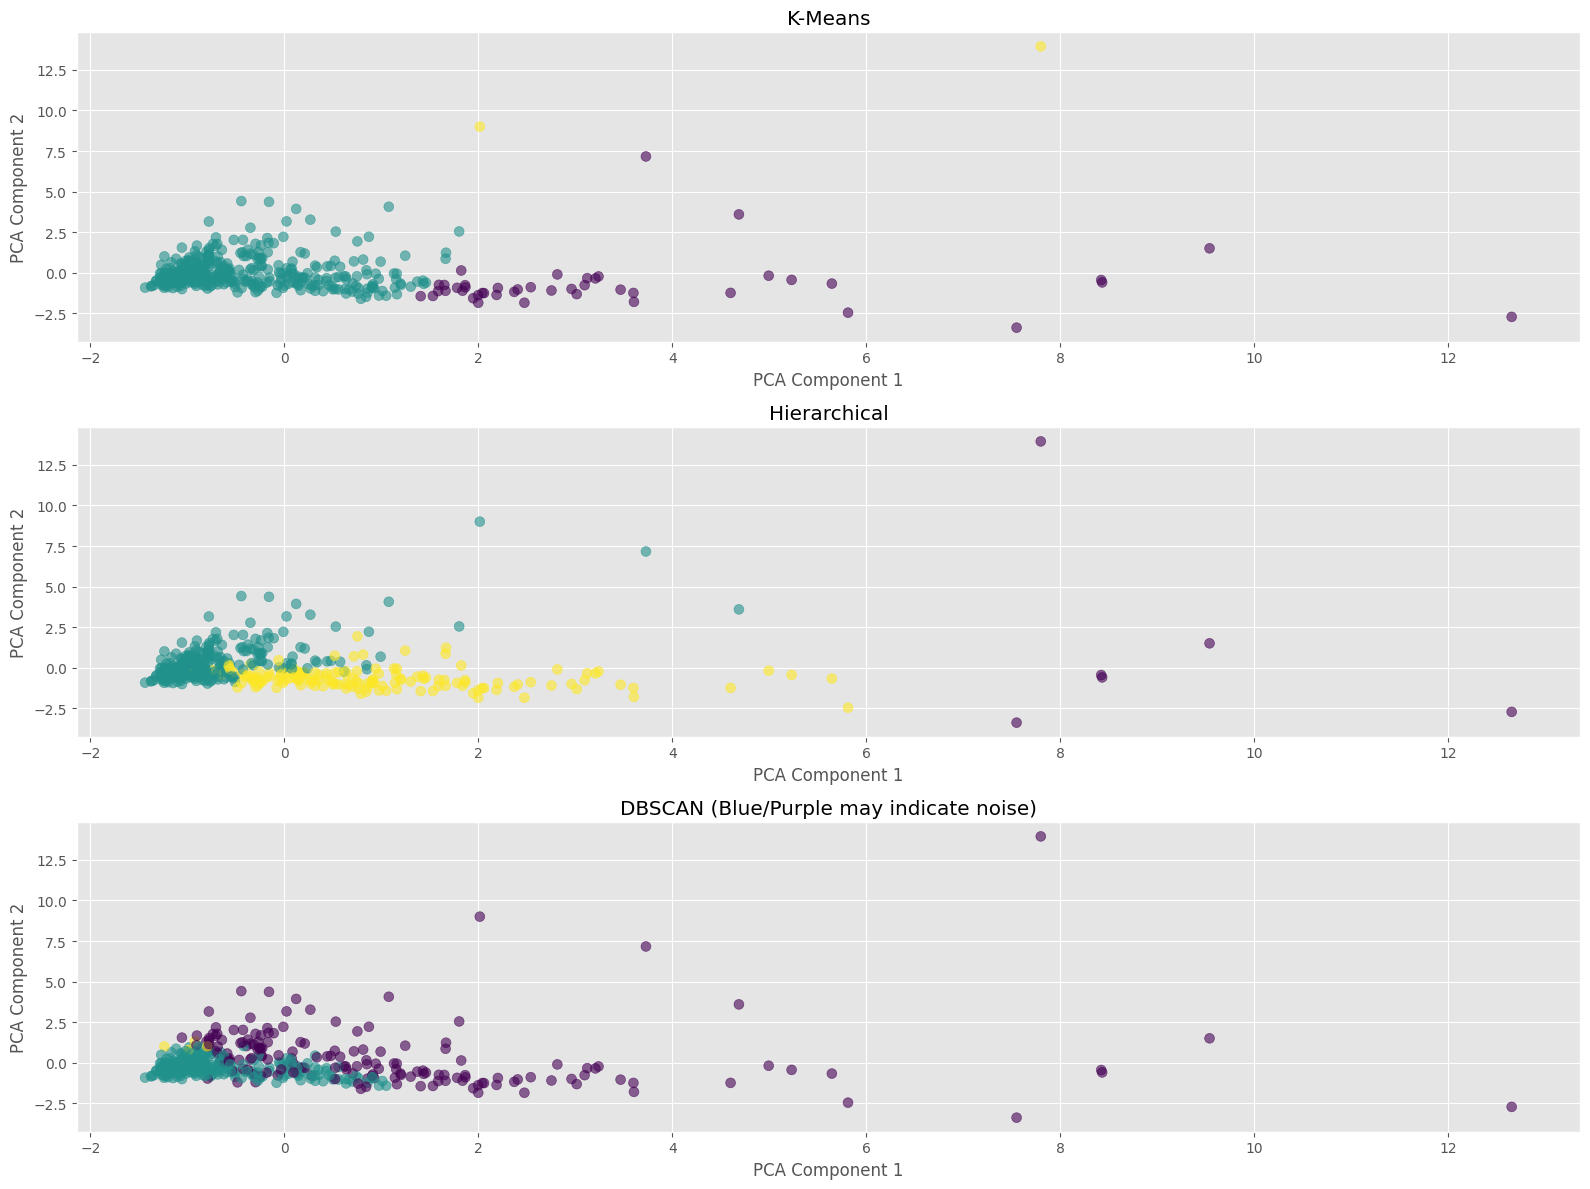

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

def plot_cluster(ax, labels, title):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plot_cluster(axes[0], kmeans_labels, "K-Means")
plot_cluster(axes[1], agg_labels, "Hierarchical")
plot_cluster(axes[2], dbscan_labels, "DBSCAN (Blue/Purple may indicate noise)")

plt.tight_layout()
plt.show()

WCSSE (Inertia) for k=3: 1608.43


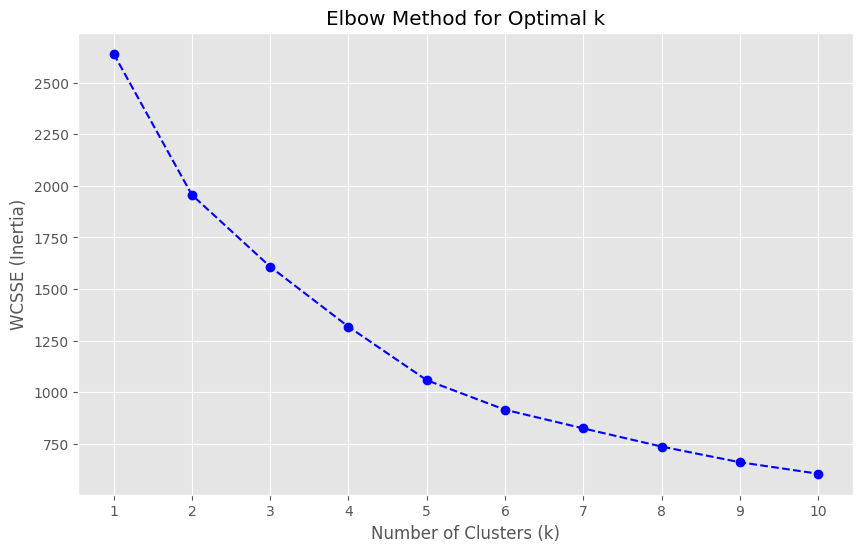

In [6]:
print(f"WCSSE (Inertia) for k=3: {kmeans.inertia_:.2f}")

wcsse = []
possible_k_values = range(1, 11)

for i in possible_k_values:
    km = KMeans(n_clusters=i, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcsse.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, wcsse, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSSE (Inertia)')
plt.xticks(possible_k_values)
plt.grid(True)
plt.show()

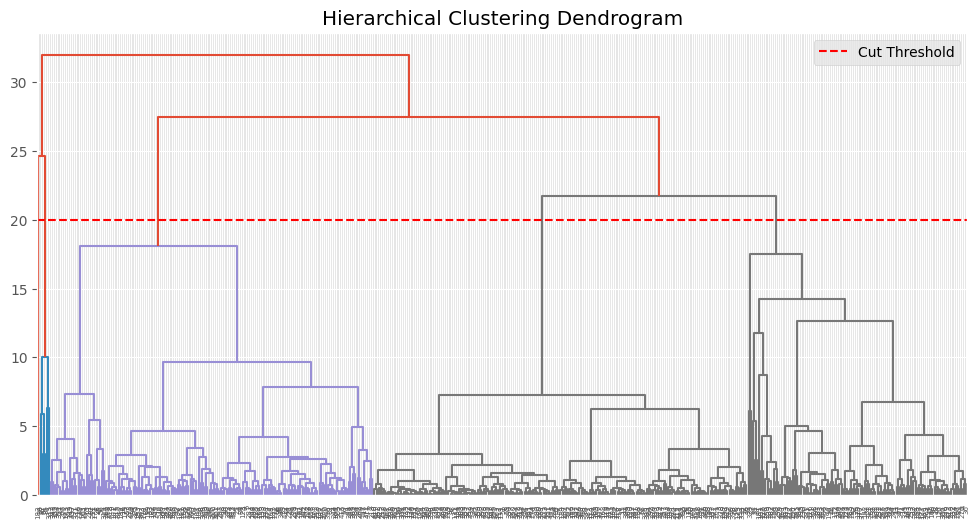

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram")
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.axhline(y=20, color='r', linestyle='--', label='Cut Threshold')
plt.legend()
plt.show()

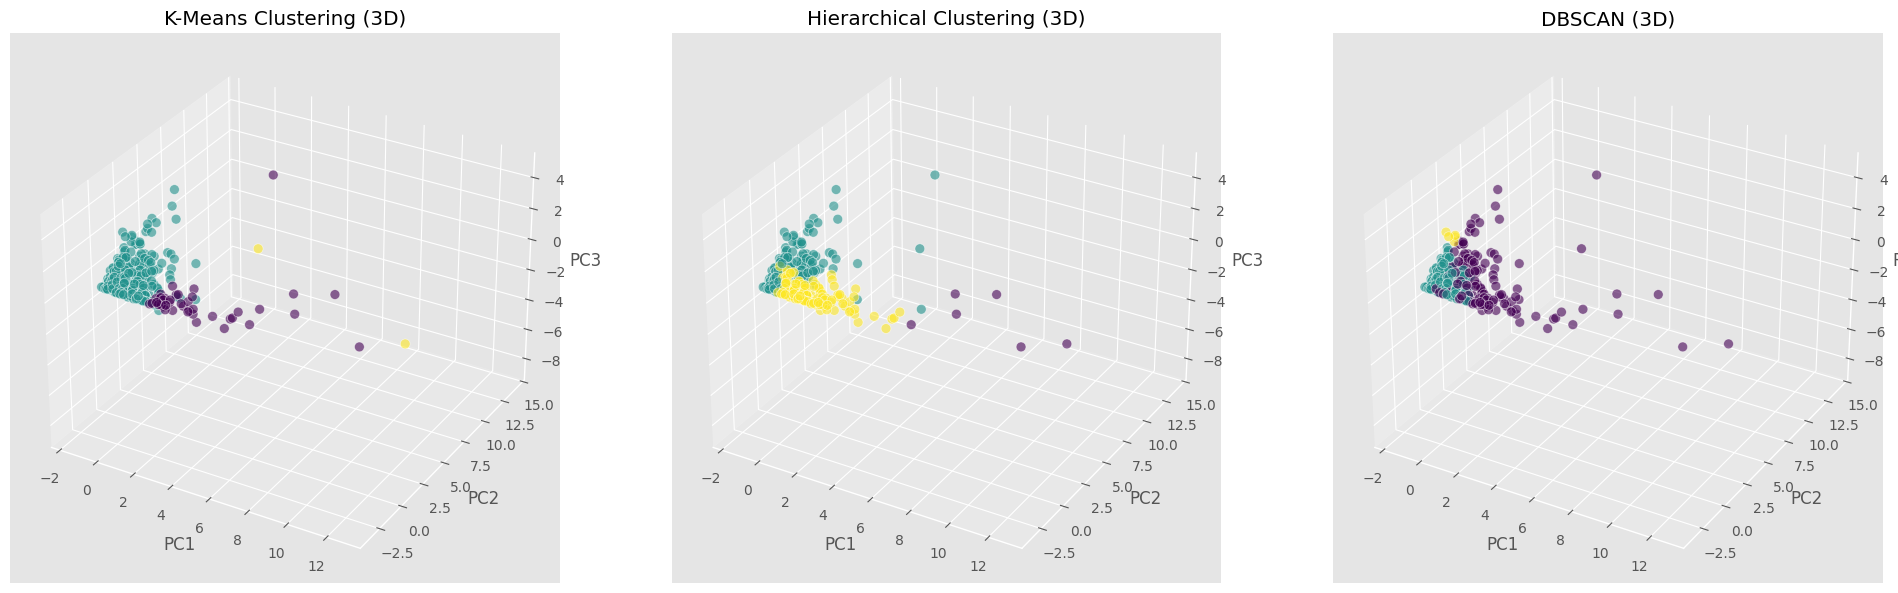

In [8]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
sc1 = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                  c=kmeans_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
ax1.set_title("K-Means Clustering (3D)")
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
sc2 = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                  c=agg_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
ax2.set_title("Hierarchical Clustering (3D)")
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
sc3 = ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                  c=dbscan_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
ax3.set_title("DBSCAN (3D)")
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')

plt.tight_layout()
plt.show()

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

def create_trace(labels, name, scene_idx):
    return go.Scatter3d(
        x=X_pca_3d[:, 0],
        y=X_pca_3d[:, 1],
        z=X_pca_3d[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='Viridis',
            opacity=0.8,
            line=dict(width=0)
        ),
        name=name,
        showlegend=False
    )

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=("K-Means", "Hierarchical", "DBSCAN")
)


fig.add_trace(create_trace(kmeans_labels, "K-Means", 1), row=1, col=1)

fig.add_trace(create_trace(agg_labels, "Hierarchical", 2), row=1, col=2)

fig.add_trace(create_trace(dbscan_labels, "DBSCAN", 3), row=1, col=3)

fig.update_layout(
    title_text="3D Interactive Clustering Comparison (Rotatable)",
    height=600,
    width=1200,
    scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'),
    scene2=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'),
    scene3=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'),
)

fig.show()